# EfficientNet

In [2]:
import os

import tensorflow as tf
import cv2
import pydicom
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Transform Data

In [3]:
train = pd.read_csv('E:/Projects/osic-pulmonary-fibrosis-progression/data/train.csv')

In [4]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [5]:
train.SmokingStatus.unique()

array(['Ex-smoker', 'Never smoked', 'Currently smokes'], dtype=object)

In [6]:
def get_tab(df):
    " raturn an array which contains each patient normalized age, sex and smoking status"
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0].lower() == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector)

In [7]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())): # i index, p patient id
    sub = train.loc[train.Patient == p, :] # find all data (weeks, FVC, Percent, Age, Sex, SmokingStatus) of a unique patient
    fvc = sub.FVC.values # fvc values of the patient during the follow-up
    weeks = sub.Weeks.values # follow-up weeks
    c = np.vstack([weeks, np.ones(len(weeks))]).T # create an array by the follow-up weeks of shape(len(weeks),2)
    a, b = np.linalg.lstsq(c, fvc)[0] # least-square sol, a=gradient matrix, b=right hand matrix 
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

C:\Users\shazz\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [8]:
def get_img(path):
    " read DICOM dataset and return resize images of size (512,512,1)"
    d = pydicom.dcmread(path) # read and parse the CT scan images (in DICOM format)
    resized_image = cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512,512))
    return resized_image

In [9]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size):
#        "key=patient, a=gradient matrix, tab=a particular patient's data"
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'E:/Projects/osic-pulmonary-fibrosis-progression/data/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size) # randomly chooses n=batch_size number of patients
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0] # chooses some randomly images for kth patient
                img = get_img(f'E:/Projects/osic-pulmonary-fibrosis-progression/data/train/{k}/{i}') # resizes ith image of kth patient
                x.append(img) # append kth patient's image data in the list x
                a.append(self.a[k]) # append kth patient's gradinet in the list a
                tab.append(self.tab[k]) # append kth patient's tabular data in the tab list
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab) # convert list to array
        x = np.expand_dims(x, axis=-1) 
        return [x, tab] , a

## Build the model

In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, GaussianNoise, 
    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate 
)

In [11]:
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,)) # indicates that the expected input will be batches of 4-dimensional vectors
    x2 = GaussianNoise(0.2)(inp2) # to mitigate overfitting
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    return model

In [12]:
MODEL_CLASS = 'b1'
base_model = build_model(shape=(512, 512, 1), model_class=MODEL_CLASS)
base_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
efficientnet-b1 (Functional)    (None, 16, 16, 1280) 6574656     input_1[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnet-b1[0][0]            
_______________________________________________________________________________________

## Compile and train the model

In [13]:
BATCH_SIZE = 8
EPOCHS = 30
LR = 0.003
SAVE_BEST = True

In [14]:
P = np.array(P)
subs = []
folds_history = []
    
er = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-3,patience=10,verbose=1,mode="auto",baseline=None,
      restore_best_weights=True,) #Stop training when a monitored metric has stopped improving.

cpt = tf.keras.callbacks.ModelCheckpoint(filepath=f'C:/Users/shazz/499/EfficientNet/models/{MODEL_CLASS}_{EPOCHS}.h5',monitor='val_loss',verbose=1, 
    save_best_only=SAVE_BEST,mode='auto') #to save model or weights in a checkpoint file at lowest validation loss

rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5, verbose=1, min_lr=1e-8) 
     #Reduce learning rate when a metric has stopped improving.
     # if improvement stops, after 5 epochs learnining rate will be reduced

model = build_model(model_class=MODEL_CLASS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mae") 
history = model.fit(IGenerator(keys=P, a = A, tab = TAB, batch_size=BATCH_SIZE), 
                    steps_per_epoch = 32,
                    validation_data=IGenerator(keys=P, a = A, tab = TAB, batch_size=BATCH_SIZE),
                    validation_steps = 16, 
                    callbacks = [cpt, rlp], 
                    epochs=EPOCHS)
folds_history.append(history.history)
print('Training done!')

Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 4.6026 
Epoch 00001: val_loss improved from inf to 3945.89844, saving model to C:/Users/shazz/499/EfficientNet/models\b1_30.h5
32/32 [==============================] - 382s 12s/step - loss: 4.6026 - val_loss: 3945.8984
Epoch 2/30
32/32 [==============================] - ETA: 0s - loss: 4.3233 
Epoch 00002: val_loss improved from 3945.89844 to 28.07581, saving model to C:/Users/shazz/499/EfficientNet/models\b1_30.h5
32/32 [==============================] - 380s 12s/step - loss: 4.3233 - val_loss: 28.0758
Epoch 3/30
32/32 [==============================] - ETA: 0s - loss: 4.3425 
Epoch 00003: val_loss did not improve from 28.07581
32/32 [==============================] - 401s 13s/step - loss: 4.3425 - val_loss: 66.4553
Epoch 4/30
32/32 [==============================] - ETA: 0s - loss: 4.4699 
Epoch 00004: val_loss improved from 28.07581 to 4.62067, saving model to C:/Users/shazz/499/EfficientNet/models\b1_30.h5
32/32 [=

In [15]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'EffNetb1_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'EffNetb1_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Visualize training results

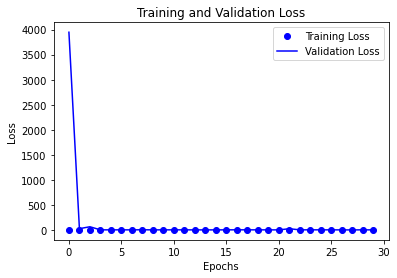

In [69]:
result_dir = 'C:/Users/shazz/499/EfficientNet/results/B1/'

import tikzplotlib

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.plot(epochs_range, loss, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.savefig(result_dir + 'b1_loss.png')
plt.savefig(result_dir + 'b1_loss.pdf', dpi=150)
tikzplotlib.save(result_dir + 'b1_loss.tex')

plt.show()

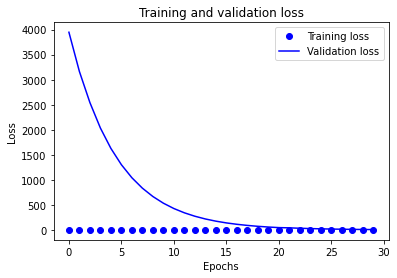

In [70]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs_range,
         smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs_range,
         smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.savefig(result_dir + 'b1_loss_smooth.png')
plt.savefig(result_dir + "b1_loss_smooth.pdf", dpi=150)
tikzplotlib.save(result_dir + 'b1_loss_smooth.tex')

plt.show()

In [71]:
import plotly as py
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
        x=np.r_[epochs_range],
        y=loss,
        name = "Training loss"
    ))

fig.add_trace(go.Scatter(
        x=np.r_[epochs_range],
        y=val_loss,
        name = "Validation loss"
    ))

fig.update_layout(
    xaxis=dict(title = "Epochs"),
    yaxis=dict(title = "Loss"),
    plot_bgcolor='white',
    title = "Training and validation loss"
)

py.offline.iplot(fig)

In [72]:
fig = go.Figure()

fig.add_trace(go.Scatter(
        x=np.r_[epochs_range],
        y=smooth_curve(loss),
        name = "Training loss"
    ))

fig.add_trace(go.Scatter(
        x=np.r_[epochs_range],
        y=smooth_curve(val_loss),
        name = "Validation loss"
    ))

fig.update_layout(
    xaxis=dict(title = "Epochs"),
    yaxis=dict(title = "Loss"),
    plot_bgcolor='white',
    title = "Training and validation loss"
)

py.offline.iplot(fig)